In [50]:
import pandas as pd
from pathlib import Path 
import re
import string

> reading in the data, verifying that everything is correct

In [27]:
txt = Path ("/Users/emilyzou/Desktop/pol/data/merged.txt").read_text()

In [28]:
test = txt.split ('Anonymous ID')

In [29]:
#get rid of the image metadata
pattern = r'\nView SameOCRGoogleiqdbSauceNAOTrace\s.*?\(\.\.\.\)\.jpg,\s\d+KiB,\s\d{2,4}x\d{2,4}'
def remove_pattern_from_list(word_string):
    return re.sub(pattern, '', word_string) 

clean1 = [remove_pattern_from_list(m) for m in test]

In [38]:
def splitstring(input_string):
    pattern = r"(:.*?)(ViewReport\n)(.*)"
    match = re.match(pattern, input_string, re.DOTALL)
    
    if match:
        identifier = match.group(1).strip()  
        text = match.group(3).strip()  
        return identifier, text
    else:
        return "No match found"

In [40]:
templist = [splitstring(m) for m in clean1]

In [52]:
templist = templist[1:]

>> splitting the data into posts, replies, quotes and tagging it with date and ID 

>> step one - making a spreadsheet with everything

In [ ]:
paramore = [m[0] for m in templist] # to take a peek at what the identifier structure is 

In [93]:
def anonidget (elem): 
    return elem.split()[0] if elem else '' 
 
def date_get(s): 
    pattern = r'\b\w{3} \d{1,2} \w{3} \d{4} \d{2}:\d{2}:\d{2}\b'
    match = re.search(pattern, s)
    result = match.group(0) if match else ''
    return result 

def threadnoget (s): 
    match = re.search(r'No\.\s*(\S+)', s)
    result = match.group(1) if match else ''
    return result 

def replyget(s):
    match = re.search(r'Replies: \d+', s)
    result = match.group(1) if match else ''
    return result

In [111]:
# to be improved on... im not sure what my priority should be right now 

df = pd.DataFrame (templist, columns = ['Identifier', 'Text']) 
df['anonid'] = df['Identifier'].apply(anonidget)
df['date'] = df['Identifier'].apply(date_get)
df['number'] = df['Identifier'].apply(threadnoget)

In [113]:
df.to_csv("11_6_fulldataset.csv")

In [114]:
# its too big lol
split_index = len(df) // 2
df_part1 = df.iloc[:split_index]
df_part2 = df.iloc[split_index:]
df_part1.to_csv('11_6_fulldatapart1.csv', index=False)
df_part2.to_csv('11_6_fulldatapart2.csv', index=False)

In [ ]:
## lets get all the items that were original posts (they have "Replies:" at the end of their identifiers)
def filter_replies(list_of_lists):
    pattern = r"Replies: \d+( View)?$"
    filtered_list = [sublist for sublist in list_of_lists if re.search(pattern, sublist[0])] 
    return filtered_list

postlist = filter_replies(templist)

postdf = pd.DataFrame(postlist, columns = ['Identifier', 'Text'])
postdf['anonid'] = postdf['Identifier'].apply(anonidget)
postdf['date'] = postdf['Identifier'].apply(date_get)
postdf['number'] = postdf['Identifier'].apply(threadnoget)

In [97]:
## categorizing quoted by and removing it from the text
def process_quotes(s):
    if "Quoted By" in s: 
        return re.findall(r'>>(\d+)\n', s)
    else:
        modified_string = s  # no modification needed if "Quoted By" is not present
        return "No Quote"

postdf['Quoted_By'] = postdf['Text'].apply(process_quotes)

def stripper (s): 
    if 'Quoted By' in s:
        cleaned_string = re.sub(r'Quoted By:|>>\d+\n', '', s)
        return cleaned_string.strip()
    else: 
        return s

postdf ['Text'] = postdf['Text'].apply(stripper)

In [98]:
## just checking that we did this right. these should all be empty 
postdf['replyto'] = postdf['Text'].apply(lambda text: re.findall(r'>>(\d+)', text))

In [101]:
postdf = postdf.drop_duplicates(subset=['Identifier'])

In [109]:
postdf['date'] = pd.to_datetime(postdf['date'], format='%a %d %b %Y %H:%M:%S')

# time series visualization, converting dates into week buckets
start_date = '2022-09-01'
end_date = "2024-10-31"

postdf = postdf[(postdf['date'] >= start_date) & (postdf['date'] <= end_date)]
postdf ['month'] = postdf['date'].dt.to_period('M').apply(lambda r: r.start_time)

month_counts = postdf['month'].value_counts().reset_index()
month_counts.columns = ['month', 'count']


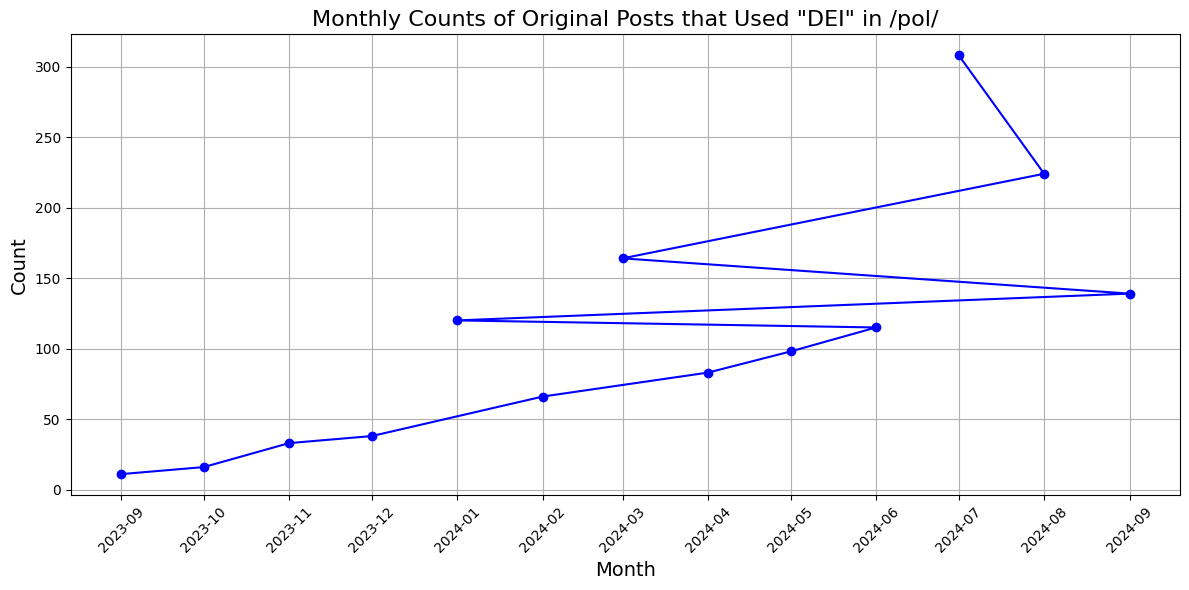

In [110]:
# why does it look like this

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
date = month_counts['month'] 
value = month_counts ['count']

plt.figure(figsize=(12, 6))

plt.plot(date, value, marker='o', linestyle='-', color='b')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  

plt.title('Monthly Counts of Original Posts that Used "DEI" in /pol/', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)


plt.xticks(rotation=45)


plt.grid()

# Adjust layout for better fit
plt.tight_layout()

# Show the plot
plt.show()

## replies 

In [70]:
def get_replies(list_of_lists):
    pattern = r"Replies: \d+( View)?$"
    filtered_list = [sublist for sublist in list_of_lists if not re.search(pattern, sublist[0])] 
    return filtered_list

replylist = get_replies(templist)

In [81]:
replydf = pd.DataFrame(replylist, columns=['Identifier', 'Text'])
replydf

,Identifier,Text
0,:+XF1CsQm Sat 01 Oct 2022 12:41:09 No.397853920,">>397853706\nwhat is the topic, then?\nYou're ..."
1,:sdTLdxFE Sat 01 Oct 2022 12:28:40 No.397852409,>>397851060\nHe tried to usurp Roman Paganism....
2,:Ytn2j+6s Sat 01 Oct 2022 10:01:18 No.397834023,>>397814529\n\nLots of anons posting ITT about...
3,:ZJmNPj22 Fri 30 Sep 2022 23:02:24 No.397773313,>>397773085\nBlack babies are better than abor...
4,:sjVRzmfL Fri 30 Sep 2022 19:23:25 No.397753590,The left loves abortion and hates children due...
...,...,...
67263,:kecsvdvI Wed 30 Oct 2024 22:14:55 No.48646562...,Quoted By:\n>>486464882\nTHE CAN BARELY GASLIG...
67264,:EF5Mz2zI Wed 30 Oct 2024 22:02:24 No.48646490...,Quoted By:\n>>486464363\nHere's my objective a...
67265,:cUMz4T2R Wed 30 Oct 2024 21:55:11 No.48646451...,Quoted By:\n>>486462545\nThere are a bunch of ...
67266,:0egXPX4Z Wed 30 Oct 2024 21:34:59 No.48646320...,Quoted By:\n>>486462545\n>But what does this m...


In [83]:
replydf['anonid'] = replydf['Identifier'].apply(anonidget)
replydf['date'] = replydf['Identifier'].apply(date_get)
replydf['number'] = replydf['Identifier'].apply(threadnoget)

In [88]:
## categorizing quoted by and removing it from the text
def process_quotes(s):
    if "Quoted By" in s: 
        return re.findall(r'>>(\d+)\n', s)
    else:
        modified_string = s  # No modification needed if "Quoted By" is not present
        return "No Quote"

replydf['Quoted_By'] = replydf['Text'].apply(process_quotes)

def stripper (s): 
    if 'Quoted By' in s:
        cleaned_string = re.sub(r'Quoted By:|>>\d+\n', '', s)
        return cleaned_string.strip()
    else: 
        return s

replydf ['Text'] = replydf['Text'].apply(stripper)

In [90]:
## getting information about which threads the poster is replying to 
replydf['replyto'] = replydf['Text'].apply(lambda text: re.findall(r'>>(\d+)', text))

In [91]:
replydf

,Identifier,Text,anonid,date,number,Quoted_By,replyto
0,:+XF1CsQm Sat 01 Oct 2022 12:41:09 No.397853920,">>397853706\nwhat is the topic, then?\nYou're ...",:+XF1CsQm,Sat 01 Oct 2022 12:41:09,397853920,No Quote,[397853706]
1,:sdTLdxFE Sat 01 Oct 2022 12:28:40 No.397852409,>>397851060\nHe tried to usurp Roman Paganism....,:sdTLdxFE,Sat 01 Oct 2022 12:28:40,397852409,No Quote,[397851060]
2,:Ytn2j+6s Sat 01 Oct 2022 10:01:18 No.397834023,>>397814529\n\nLots of anons posting ITT about...,:Ytn2j+6s,Sat 01 Oct 2022 10:01:18,397834023,No Quote,[397814529]
3,:ZJmNPj22 Fri 30 Sep 2022 23:02:24 No.397773313,>>397773085\nBlack babies are better than abor...,:ZJmNPj22,Fri 30 Sep 2022 23:02:24,397773313,No Quote,[397773085]
4,:sjVRzmfL Fri 30 Sep 2022 19:23:25 No.397753590,The left loves abortion and hates children due...,:sjVRzmfL,Fri 30 Sep 2022 19:23:25,397753590,No Quote,[]
...,...,...,...,...,...,...,...
67263,:kecsvdvI Wed 30 Oct 2024 22:14:55 No.48646562...,THE CAN BARELY GASLIGHT THIS WITHIN THEIR OWN ...,:kecsvdvI,Wed 30 Oct 2024 22:14:55,486465624,[486464882],[]
67264,:EF5Mz2zI Wed 30 Oct 2024 22:02:24 No.48646490...,Here's my objective assessment of Stephen Mill...,:EF5Mz2zI,Wed 30 Oct 2024 22:02:24,486464907,[486464363],[]
67265,:cUMz4T2R Wed 30 Oct 2024 21:55:11 No.48646451...,There are a bunch of reasons. There are many f...,:cUMz4T2R,Wed 30 Oct 2024 21:55:11,486464519,"[486462545, 486517619, 486517578]",[]
67266,:0egXPX4Z Wed 30 Oct 2024 21:34:59 No.48646320...,">But what does this mean?\nDEI, troons, wars, ...",:0egXPX4Z,Wed 30 Oct 2024 21:34:59,486463202,[486462545],[]
